<a href="https://colab.research.google.com/github/Nastiiasaenko/Deeplearning-Final-Project/blob/main/Sentiment_pipeline_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Creating toxic movie thing

**Out-of-Distribution (OOD):**


**Near-OOD: **

Toxic or adversarial reviews that:

Sound like movie reviews but introduce toxicity (e.g., hate speech or abuse).


Contain unrelated explicit questions or sentences, mimicking poor alignment in LLMs.

Example:
** ‚ÄúThis movie is trash. Also, is cocaine illegal in Canada?‚Äù**


## the pipeline we are trying to reproduce

**WHEN LLM is specifically asked to perform a task to sentiment predict**

6. Summary of Steps in the Pipeline

1. Input is tokenized and passed to the fine-tuned LLM.

2. The model predicts logits for ID classification.


3. Post-processing detects OOD inputs using MSP or energy scores.

**If flagged as OOD:**
4. No sentiment label is produced.

The system returns an OOD indicator.

**If classified as ID:**

5. The sentiment label (positive/negative) is returned.


#### More on the workflow - the idea is to use LLM for inference here and test like this

The LLM itself detects OOD inputs internally. Here's how:

Input Flow:

All inputs (ID or OOD) are passed directly to the fine-tuned LLM.

***Detection Logic:***

The logits generated by the LLM are analyzed using:

Maximum Softmax Probability (MSP).

Energy-Based Scoring.

These methods determine whether the input is OOD.

Classification:

If the input is flagged as ID, the logits are used for classification (e.g., positive/negative sentiment).

If the input is flagged as OOD, it is excluded or flagged without producing a classification.

Why the LLM Handles Detection and Classification Internally
The LLM is already generating logits for classification.

Adding OOD detection based on those logits (e.g., via MSP or energy scores) avoids duplicating effort and simplifies the pipeline.


In [ ]:
### Mount to drive and save
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define a directory in Google Drive
save_dir = '/content/drive/MyDrive/MIDS/ECE661/DL_mine/mycodes'


Mounted at /content/drive


In [ ]:
!pip install datasets

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 179.3/179.3 kB 17.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolve

In [ ]:
### Mount to drive and save
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define a directory in Google Drive
save_dir = '/content/drive/MyDrive/MIDS/ECE661/DL_mine/mycodes'


Mounted at /content/drive


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
import os

# Load SST-2 dataset
  # Shorten to 128 or fewer tokens if possible
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


sst2_dataset = load_dataset("sst2")
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize SST-2 data
def preprocess_sst2(dataset, max_length=128):
    reviews = [entry["sentence"] for entry in dataset]
    labels = [entry["label"] for entry in dataset]
    tokenized = tokenizer(reviews, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
    tokenized["labels"] = torch.tensor(labels)
    return tokenized

sst2_train = preprocess_sst2(sst2_dataset["train"])
sst2_val = preprocess_sst2(sst2_dataset["validation"])

# Save SST-2 tokenized data
save_dir = "./ood_project_data/"
os.makedirs(save_dir, exist_ok=True)
torch.save(sst2_train, os.path.join(save_dir, "sst2_train.pt"))
torch.save(sst2_val, os.path.join(save_dir, "sst2_val.pt"))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.27k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Load BeaverTails dataset
beavertails_dataset = load_dataset("PKU-Alignment/BeaverTails")
toxic_data = [entry for entry in beavertails_dataset["330k_train"] if not entry["is_safe"]]

# Short toxic phrases (for Near-OOD)
toxic_phrases = [entry["response"] for entry in toxic_data if len(entry["response"].split()) < 15]
torch.save(toxic_phrases, os.path.join(save_dir, "toxic_phrases.pt"))

# Full toxic texts (for Far-OOD)
toxic_full_texts = [f"Prompt: {entry['prompt']} Response: {entry['response']}" for entry in toxic_data]
torch.save(toxic_full_texts, os.path.join(save_dir, "toxic_full_texts.pt"))

# Excluded toxic phrases (filter by category)
excluded_categories = ["Child Abuse", "Privacy Violation"]
excluded_toxic_phrases = [
    entry["response"] for entry in toxic_data
    if not any(cat in entry["category"] for cat in excluded_categories) and len(entry["response"].split()) < 15
]
torch.save(excluded_toxic_phrases, os.path.join(save_dir, "excluded_toxic_phrases.pt"))



README.md:   0%|          | 0.00/6.95k [00:00<?, ?B/s]

train.jsonl.xz:   0%|          | 0.00/31.1M [00:00<?, ?B/s]

test.jsonl.xz:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

train.jsonl.gz:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

test.jsonl.gz:   0%|          | 0.00/545k [00:00<?, ?B/s]

Generating 330k_train split:   0%|          | 0/300567 [00:00<?, ? examples/s]

Generating 330k_test split:   0%|          | 0/33396 [00:00<?, ? examples/s]

Generating 30k_train split:   0%|          | 0/27186 [00:00<?, ? examples/s]

Generating 30k_test split:   0%|          | 0/3021 [00:00<?, ? examples/s]

In [ ]:
# Create blended toxic reviews for Near-OOD
def blend_toxic_with_review(review, toxic_phrases):
    import random
    toxic_phrase = random.choice(toxic_phrases)
    return f"{review.strip()} {toxic_phrase}"

sst2_reviews = [entry["sentence"] for entry in sst2_dataset["train"]]
blended_reviews = [blend_toxic_with_review(review, toxic_phrases) for review in sst2_reviews]

# Tokenize blended toxic reviews
blended_tokenized = tokenizer(blended_reviews, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
blended_tokenized["labels"] = torch.tensor([1] * len(blended_reviews))  # Label as Near-OOD
torch.save(blended_tokenized, os.path.join(save_dir, "near_ood_classifier_data.pt"))


In [ ]:
# Create blended toxic reviews with excluded toxic phrases
blended_excluded_reviews = [blend_toxic_with_review(review, excluded_toxic_phrases) for review in sst2_reviews]

# Tokenize blended reviews
blended_excluded_tokenized = tokenizer(blended_excluded_reviews, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
blended_excluded_tokenized["labels"] = torch.tensor([1] * len(blended_excluded_reviews))  # Label as Near-OOD
torch.save(blended_excluded_tokenized, os.path.join(save_dir, "near_ood_excluded_classifier_data.pt"))


In [ ]:
# Tokenize full toxic texts
far_ood_tokenized = tokenizer(toxic_full_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
far_ood_tokenized["labels"] = torch.tensor([1] * len(toxic_full_texts))  # Label as Far-OOD
torch.save(far_ood_tokenized, os.path.join(save_dir, "far_ood_classifier_data.pt"))


In [ ]:
# Load training datasets
near_ood_data = torch.load(os.path.join(save_dir, "near_ood_classifier_data.pt"))
near_ood_excluded_data = torch.load(os.path.join(save_dir, "near_ood_excluded_classifier_data.pt"))
far_ood_data = torch.load(os.path.join(save_dir, "far_ood_classifier_data.pt"))

# Convert to Hugging Face Dataset
from datasets import Dataset
train_dataset_near = Dataset.from_dict(near_ood_data)
train_dataset_near_excluded = Dataset.from_dict(near_ood_excluded_data)
train_dataset_far = Dataset.from_dict(far_ood_data)


<ipython-input-9-63b320537f03>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  near_ood_data = torch.load(os.path.join(save_dir, "near_ood_classifier_data.pt"))
<ipython-in

In [ ]:
train_dataset_far

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 166382
})

In [ ]:
from torch.utils.data import DataLoader

# Create a DataLoader to inspect the batch
train_dataloader = DataLoader(train_dataset_near, batch_size=8)  # Adjust batch_size as needed

# Inspect a single batch
for batch in train_dataloader:
    print(batch)  # Print the entire batch
    # Optional: Check specific keys
    print("Input IDs:", batch["input_ids"])
    print("Attention Mask:", batch["attention_mask"])
    print("Labels:", batch["labels"])
    break  # Only print the first batch


{'input_ids': [tensor([101, 101, 101, 101, 101, 101, 101, 101]), tensor([ 5342,  3397,  2008,  3464,  2006,  2008, 16691,  1997]), tensor([ 2047,  2053,  7459, 12580,  1996,  1005,  2008,  7842]), tensor([ 3595, 15966,  2049,  8510,  5409,  1055,  1996, 14194]), tensor([8496, 1010, 3494, 2000, 7195, 2521, 2472, 2100]), tensor([ 2013,  2069,  1998,  3961,  1011,  2205,  1997, 11265]), tensor([ 1996,  4450, 10639,  1996,  1997, 13800,  2107,  4103]), tensor([18643,  2098,  2015,  2168,  1011,  2000,  5365,  1010]), tensor([ 3197, 18201,  2242,  2802,  1996,  7857, 27858, 29294]), tensor([1996, 2015, 2738, 1045, 1011, 2107, 2015, 1010]), tensor([ 2591,  6240,  3376,  2228, 11265, 23105,  2004, 14320]), tensor([ 3036,  1011,  2055,  1996, 17811,  3949, 16419,  3077]), tensor([ 2193, 28496,  2529,  2047, 18856,  2990,  2399,   102]), tensor([ 2005,  1010,  3267,  2563, 17322,  7369,  2064,     0]), tensor([ 5074,  2482, 11025, 11579,  2015,  4724,  2145,     0]), tensor([15536,  3490,  1037

In [ ]:
# Inspect a single batch from the dataset
print(train_dataset_near[0])
print(train_dataset_near.column_names)

# Check dataset sizes
print(f"Train dataset size: {len(train_dataset_near)}")
print(f"Validation dataset size: {len(train_dataset_near)}")


{'input_ids': [101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 1996, 2591, 3036, 2193, 2005, 5074, 15536, 9102, 2003, 5989, 2509, 1011, 5718, 1011, 26628, 2487, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,

# blending


In [ ]:
# Load tokenized SST-2 and toxic datasets
sst2_train = torch.load(os.path.join(save_dir, "sst2_train.pt"))
blended_tokenized = torch.load(os.path.join(save_dir, "near_ood_classifier_data.pt"))
blended_excluded_tokenized = torch.load(os.path.join(save_dir, "near_ood_excluded_classifier_data.pt"))
far_ood_tokenized = torch.load(os.path.join(save_dir, "far_ood_classifier_data.pt"))


<ipython-input-24-ae73da96c97c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sst2_train = torch.load(os.path.join(save_dir, "sst2_train.pt"))
<ipython-input-24-ae73da96c

In [ ]:
# Combine SST-2 and blended toxic reviews for Near-OOD
combined_input_ids = torch.cat([sst2_train["input_ids"], blended_tokenized["input_ids"]], dim=0)
combined_attention_mask = torch.cat([sst2_train["attention_mask"], blended_tokenized["attention_mask"]], dim=0)
combined_labels = torch.cat([sst2_train["labels"], blended_tokenized["labels"]], dim=0)

# Save the combined dataset
near_ood_combined_data = {
    "input_ids": combined_input_ids,
    "attention_mask": combined_attention_mask,
    "labels": combined_labels,
}
torch.save(near_ood_combined_data, os.path.join(save_dir, "near_ood_combined_data.pt"))


In [ ]:
# Combine SST-2 and excluded toxic reviews for Excluded Near-OOD
excluded_combined_input_ids = torch.cat([sst2_train["input_ids"], blended_excluded_tokenized["input_ids"]], dim=0)
excluded_combined_attention_mask = torch.cat([sst2_train["attention_mask"], blended_excluded_tokenized["attention_mask"]], dim=0)
excluded_combined_labels = torch.cat([sst2_train["labels"], blended_excluded_tokenized["labels"]], dim=0)

# Save the combined dataset
excluded_near_ood_combined_data = {
    "input_ids": excluded_combined_input_ids,
    "attention_mask": excluded_combined_attention_mask,
    "labels": excluded_combined_labels,
}
torch.save(excluded_near_ood_combined_data, os.path.join(save_dir, "near_ood_excluded_combined_data.pt"))


In [ ]:
# Combine SST-2 and Far-OOD toxic reviews
far_combined_input_ids = torch.cat([sst2_train["input_ids"], far_ood_tokenized["input_ids"]], dim=0)
far_combined_attention_mask = torch.cat([sst2_train["attention_mask"], far_ood_tokenized["attention_mask"]], dim=0)
far_combined_labels = torch.cat([sst2_train["labels"], far_ood_tokenized["labels"]], dim=0)

# Save the combined dataset
far_ood_combined_data = {
    "input_ids": far_combined_input_ids,
    "attention_mask": far_combined_attention_mask,
    "labels": far_combined_labels,
}
torch.save(far_ood_combined_data, os.path.join(save_dir, "far_ood_combined_data.pt"))


In [ ]:
# Check the shapes of combined datasets
print("Near-OOD Combined Dataset:")
print(f"Input IDs: {near_ood_combined_data['input_ids'].shape}")
print(f"Attention Mask: {near_ood_combined_data['attention_mask'].shape}")
print(f"Labels: {near_ood_combined_data['labels'].shape}")

print("Excluded Near-OOD Combined Dataset:")
print(f"Input IDs: {excluded_near_ood_combined_data['input_ids'].shape}")
print(f"Attention Mask: {excluded_near_ood_combined_data['attention_mask'].shape}")
print(f"Labels: {excluded_near_ood_combined_data['labels'].shape}")

print("Far-OOD Combined Dataset:")
print(f"Input IDs: {far_ood_combined_data['input_ids'].shape}")
print(f"Attention Mask: {far_ood_combined_data['attention_mask'].shape}")
print(f"Labels: {far_ood_combined_data['labels'].shape}")


Near-OOD Combined Dataset:
Input IDs: torch.Size([134698, 128])
Attention Mask: torch.Size([134698, 128])
Labels: torch.Size([134698])
Excluded Near-OOD Combined Dataset:
Input IDs: torch.Size([134698, 128])
Attention Mask: torch.Size([134698, 128])
Labels: torch.Size([134698])
Far-OOD Combined Dataset:
Input IDs: torch.Size([233731, 128])
Attention Mask: torch.Size([233731, 128])
Labels: torch.Size([233731])


In [ ]:
 # Check sizes for Near-OOD
print("Near-OOD Combined Dataset:")
print(f"Input IDs: {near_ood_combined_data['input_ids'].size()}")
print(f"Attention Mask: {near_ood_combined_data['attention_mask'].size()}")
print(f"Labels: {near_ood_combined_data['labels'].size()}")

# Check sizes for Excluded Near-OOD
print("Excluded Near-OOD Combined Dataset:")
print(f"Input IDs: {excluded_near_ood_combined_data['input_ids'].size()}")
print(f"Attention Mask: {excluded_near_ood_combined_data['attention_mask'].size()}")
print(f"Labels: {excluded_near_ood_combined_data['labels'].size()}")

# Check sizes for Far-OOD
print("Far-OOD Combined Dataset:")
print(f"Input IDs: {far_ood_combined_data['input_ids'].size()}")
print(f"Attention Mask: {far_ood_combined_data['attention_mask'].size()}")
print(f"Labels: {far_ood_combined_data['labels'].size()}")


Near-OOD Combined Dataset:
Input IDs: torch.Size([134698, 128])
Attention Mask: torch.Size([134698, 128])
Labels: torch.Size([134698])
Excluded Near-OOD Combined Dataset:
Input IDs: torch.Size([134698, 128])
Attention Mask: torch.Size([134698, 128])
Labels: torch.Size([134698])
Far-OOD Combined Dataset:
Input IDs: torch.Size([233731, 128])
Attention Mask: torch.Size([233731, 128])
Labels: torch.Size([233731])


In [ ]:
from collections import Counter

# Check label distribution for Near-OOD
near_ood_labels = near_ood_combined_data["labels"].tolist()
print("Near-OOD Label Distribution:", Counter(near_ood_labels))

# Check label distribution for Excluded Near-OOD
excluded_near_ood_labels = excluded_near_ood_combined_data["labels"].tolist()
print("Excluded Near-OOD Label Distribution:", Counter(excluded_near_ood_labels))

# Check label distribution for Far-OOD
far_ood_labels = far_ood_combined_data["labels"].tolist()
print("Far-OOD Label Distribution:", Counter(far_ood_labels))


Near-OOD Label Distribution: Counter({1: 104918, 0: 29780})
Excluded Near-OOD Label Distribution: Counter({1: 104918, 0: 29780})
Far-OOD Label Distribution: Counter({1: 203951, 0: 29780})


In [ ]:
# Inspect a sample from Near-OOD
print("Sample from Near-OOD Dataset:")
print(f"Input IDs: {near_ood_combined_data['input_ids'][0]}")
print(f"Attention Mask: {near_ood_combined_data['attention_mask'][0]}")
print(f"Label: {near_ood_combined_data['labels'][5553]}")

# Inspect a sample from Excluded Near-OOD
print("Sample from Excluded Near-OOD Dataset:")
print(f"Input IDs: {excluded_near_ood_combined_data['input_ids'][0]}")
print(f"Attention Mask: {excluded_near_ood_combined_data['attention_mask'][0]}")
print(f"Label: {excluded_near_ood_combined_data['labels'][0]}")

# Inspect a sample from Far-OOD
print("Sample from Far-OOD Dataset:")
print(f"Input IDs: {far_ood_combined_data['input_ids'][0]}")
print(f"Attention Mask: {far_ood_combined_data['attention_mask'][0]}")
print(f"Label: {far_ood_combined_data['labels'][0]}")


Sample from Near-OOD Dataset:
Input IDs: tensor([  101,  5342,  2047,  3595,  8496,  2013,  1996, 18643,  3197,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,  

In [ ]:
import torch
import random

# Helper function to balance and downsample a dataset
def downsample_and_balance(dataset, id_limit=15000, ood_limit=15000):
    """
    Downsample and balance the dataset to have equal numbers of ID and OOD examples.
    """
    input_ids = dataset["input_ids"]
    attention_mask = dataset["attention_mask"]
    labels = dataset["labels"]

    # Separate ID (label 0) and OOD (label 1)
    id_indices = [i for i, label in enumerate(labels) if label == 0]
    ood_indices = [i for i, label in enumerate(labels) if label == 1]

    # Randomly sample from ID and OOD indices
    sampled_id_indices = random.sample(id_indices, min(len(id_indices), id_limit))
    sampled_ood_indices = random.sample(ood_indices, min(len(ood_indices), ood_limit))

    # Combine sampled indices and shuffle
    sampled_indices = sampled_id_indices + sampled_ood_indices
    random.shuffle(sampled_indices)

    # Create the downsampled dataset
    downsampled_data = {
        "input_ids": input_ids[sampled_indices],
        "attention_mask": attention_mask[sampled_indices],
        "labels": labels[sampled_indices],
    }
    return downsampled_data

# Load the datasets
near_ood_combined_data = torch.load(os.path.join(save_dir, "near_ood_combined_data.pt"))
excluded_near_ood_combined_data = torch.load(os.path.join(save_dir, "near_ood_excluded_combined_data.pt"))
far_ood_combined_data = torch.load(os.path.join(save_dir, "far_ood_combined_data.pt"))

# Downsample and balance each dataset
balanced_near_ood = downsample_and_balance(near_ood_combined_data, id_limit=15000, ood_limit=15000)
balanced_excluded_near_ood = downsample_and_balance(excluded_near_ood_combined_data, id_limit=15000, ood_limit=15000)
balanced_far_ood = downsample_and_balance(far_ood_combined_data, id_limit=15000, ood_limit=15000)

# Save the balanced datasets
torch.save(balanced_near_ood, os.path.join(save_dir, "balanced_near_ood.pt"))
torch.save(balanced_excluded_near_ood, os.path.join(save_dir, "balanced_excluded_near_ood.pt"))
torch.save(balanced_far_ood, os.path.join(save_dir, "balanced_far_ood.pt"))


<ipython-input-37-1c10f69cccfc>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  near_ood_combined_data = torch.load(os.path.join(save_dir, "near_ood_combined_data.pt"))
<i

In [ ]:
# Load balanced datasets
balanced_near_ood = torch.load(os.path.join(save_dir, "balanced_near_ood.pt"))
balanced_excluded_near_ood = torch.load(os.path.join(save_dir, "balanced_excluded_near_ood.pt"))
balanced_far_ood = torch.load(os.path.join(save_dir, "balanced_far_ood.pt"))

# Check label distributions
from collections import Counter

print("Balanced Near-OOD Label Distribution:", Counter(balanced_near_ood["labels"].tolist()))
print("Balanced Excluded Near-OOD Label Distribution:", Counter(balanced_excluded_near_ood["labels"].tolist()))
print("Balanced Far-OOD Label Distribution:", Counter(balanced_far_ood["labels"].tolist()))


Balanced Near-OOD Label Distribution: Counter({0: 15000, 1: 15000})
Balanced Excluded Near-OOD Label Distribution: Counter({0: 15000, 1: 15000})
Balanced Far-OOD Label Distribution: Counter({1: 15000, 0: 15000})


<ipython-input-38-a95ec4aae647>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  balanced_near_ood = torch.load(os.path.join(save_dir, "balanced_near_ood.pt"))
<ipython-inpu

In [ ]:
train_dataset_near = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_near_ood.pt")))
train_dataset_near_excluded = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_excluded_near_ood.pt")))
train_dataset_far = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_far_ood.pt")))


<ipython-input-39-af679bd27d61>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset_near = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_near_ood.

In [ ]:
from datasets import Dataset

# Load balanced datasets
train_dataset_near = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_near_ood.pt")))
train_dataset_near_excluded = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_excluded_near_ood.pt")))
train_dataset_far = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_far_ood.pt")))

# Check dataset sizes (optional)
print(f"Near-OOD Dataset Size: {len(train_dataset_near)}")
print(f"Excluded Near-OOD Dataset Size: {len(train_dataset_near_excluded)}")
print(f"Far-OOD Dataset Size: {len(train_dataset_far)}")


<ipython-input-40-5cfee3de38ce>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset_near = Dataset.from_dict(torch.load(os.path.join(save_dir, "balanced_near_ood.

Near-OOD Dataset Size: 30000
Excluded Near-OOD Dataset Size: 30000
Far-OOD Dataset Size: 30000


## Data splitting


In [ ]:
from transformers import TrainingArguments

# Common training arguments
def get_training_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=2,  # Simulate larger batch size
        num_train_epochs=3,
        logging_dir="./logs",
        fp16=True if torch.cuda.is_available() else False,  # Mixed precision for faster training
        load_best_model_at_end=True,
    )


In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer

# Load the model
near_ood_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize Trainer
trainer_near = Trainer(
    model=near_ood_model,
    args=get_training_args("./near_ood_results"),
    train_dataset=train_dataset_near,
    eval_dataset=train_dataset_near,
)

# Train the model
trainer_near.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5625, training_loss=0.1439274681939019, metrics={'train_runtime': 396.2035, 'train_samples_per_second': 227.156, 'train_steps_per_second': 14.197, 'total_flos': 2980516469760000.0, 'train_loss': 0.1439274681939019, 'epoch': 3.0})

In [ ]:
results_near = trainer_near.evaluate(eval_dataset=train_dataset_near)
print("Near-OOD Classifier Results:", results_near)


Near-OOD Classifier Results: {'eval_loss': 0.036378249526023865, 'eval_runtime': 32.6009, 'eval_samples_per_second': 920.221, 'eval_steps_per_second': 115.028, 'epoch': 3.0}


In [ ]:
# Load the model
near_ood_excluded_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize Trainer
trainer_near_excluded = Trainer(
    model=near_ood_excluded_model,
    args=get_training_args("./near_ood_excluded_results"),
    train_dataset=train_dataset_near_excluded,
    eval_dataset=train_dataset_near_excluded,
)

# Train the model
trainer_near_excluded.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5625, training_loss=0.143016956837972, metrics={'train_runtime': 396.3605, 'train_samples_per_second': 227.066, 'train_steps_per_second': 14.192, 'total_flos': 2980516469760000.0, 'train_loss': 0.143016956837972, 'epoch': 3.0})

In [ ]:
results_near_excluded = trainer_near_excluded.evaluate(eval_dataset=train_dataset_near_excluded)
print("Excluded Near-OOD Classifier Results:", results_near_excluded)


In [ ]:
# Load the model
far_ood_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Initialize Trainer
trainer_far = Trainer(
    model=far_ood_model,
    args=get_training_args("./far_ood_results"),
    train_dataset=train_dataset_far,
    eval_dataset=train_dataset_far,
)

# Train the model
trainer_far.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


TrainOutput(global_step=5625, training_loss=0.08727340952555339, metrics={'train_runtime': 399.2347, 'train_samples_per_second': 225.431, 'train_steps_per_second': 14.089, 'total_flos': 2980516469760000.0, 'train_loss': 0.08727340952555339, 'epoch': 3.0})

In [ ]:
results_far = trainer_far.evaluate(eval_dataset=train_dataset_far)
print("Far-OOD Classifier Results:", results_far)


Far-OOD Classifier Results: {'eval_loss': 0.01869555376470089, 'eval_runtime': 32.5036, 'eval_samples_per_second': 922.974, 'eval_steps_per_second': 115.372, 'epoch': 3.0}


## testing

In [ ]:
# Save the model after training
trainer_near.save_model("./near_ood_model")
trainer_near_excluded.save_model("./near_ood_excluded_model")
trainer_far.save_model("./far_ood_model")


In [ ]:
# prompt: print current working directory

import os
print(os.getcwd())

/content


In [ ]:
## on unused data ofc


from transformers import AutoModelForSequenceClassification, Trainer

# Load trained models
near_ood_model = AutoModelForSequenceClassification.from_pretrained("/content/near_ood_model")
near_ood_excluded_model = AutoModelForSequenceClassification.from_pretrained("/content/near_ood_excluded_results/checkpoint-5625")
far_ood_model = AutoModelForSequenceClassification.from_pretrained("/content/far_ood_model")


In [ ]:
import torch

# Load combined datasets
near_ood_combined_data = torch.load("./ood_project_data/near_ood_combined_data.pt")
excluded_near_ood_combined_data = torch.load("./ood_project_data/near_ood_excluded_combined_data.pt")
far_ood_combined_data = torch.load("./ood_project_data/far_ood_combined_data.pt")

# Load training datasets
train_dataset_near = torch.load("./ood_project_data/balanced_near_ood.pt")
train_dataset_near_excluded = torch.load("./ood_project_data/balanced_excluded_near_ood.pt")
train_dataset_far = torch.load("./ood_project_data/balanced_far_ood.pt")



<ipython-input-61-a9bfab8db7c4>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  near_ood_combined_data = torch.load("./ood_project_data/near_ood_combined_data.pt")
<ipython

In [ ]:
# Helper function to exclude training data
def exclude_training_data(original_data, training_data):
    # Convert data to sets for efficient exclusion
    train_input_ids = set([tuple(ids.tolist()) for ids in training_data["input_ids"]])

    # Filter unused data
    unused_input_ids = []
    unused_attention_mask = []
    unused_labels = []

    for i, input_id in enumerate(original_data["input_ids"]):
        if tuple(input_id.tolist()) not in train_input_ids:
            unused_input_ids.append(original_data["input_ids"][i])
            unused_attention_mask.append(original_data["attention_mask"][i])
            unused_labels.append(original_data["labels"][i])

    return {
        "input_ids": torch.stack(unused_input_ids),
        "attention_mask": torch.stack(unused_attention_mask),
        "labels": torch.tensor(unused_labels),
    }

# Exclude training data for Near-OOD
unused_near_ood_data = exclude_training_data(near_ood_combined_data, train_dataset_near)

# Exclude training data for Excluded Near-OOD
unused_excluded_near_ood_data = exclude_training_data(excluded_near_ood_combined_data, train_dataset_near_excluded)

# Exclude training data for Far-OOD
unused_far_ood_data = exclude_training_data(far_ood_combined_data, train_dataset_far)


In [ ]:
# Save unused data
torch.save(unused_near_ood_data, "./ood_project_data/unused_near_ood_data.pt")
torch.save(unused_excluded_near_ood_data, "./ood_project_data/unused_excluded_near_ood_data.pt")
torch.save(unused_far_ood_data, "./ood_project_data/unused_far_ood_data.pt")


In [ ]:
from datasets import Dataset

# Convert to Dataset
test_dataset_near = Dataset.from_dict(unused_near_ood_data)
test_dataset_excluded = Dataset.from_dict(unused_excluded_near_ood_data)
test_dataset_far = Dataset.from_dict(unused_far_ood_data)


In [ ]:
from collections import Counter

# Verify label distributions in test datasets
print("Test Near-OOD Label Distribution:", Counter(test_dataset_near["labels"]))
print("Test Excluded Near-OOD Label Distribution:", Counter(test_dataset_excluded["labels"]))
print("Test Far-OOD Label Distribution:", Counter(test_dataset_far["labels"]))


Test Near-OOD Label Distribution: Counter({1: 89855, 0: 14716})
Test Excluded Near-OOD Label Distribution: Counter({1: 89845, 0: 14707})
Test Far-OOD Label Distribution: Counter({1: 170453, 0: 14704})


## Evaluation pipeline

In [ ]:
from transformers import TrainingArguments, Trainer

# Define evaluation arguments
def get_eval_args(output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        per_device_eval_batch_size=16,  # Adjust batch size as needed
        logging_dir="./logs",
    )


In [ ]:
# Near-OOD Model Evaluation
trainer_near = Trainer(
    model=near_ood_model,
    args=get_eval_args("./eval_near_ood_results"),
    eval_dataset=test_dataset_near,
)
results_near = trainer_near.evaluate()
print("Evaluation Results - Near-OOD Model:", results_near)

# Excluded Near-OOD Model Evaluation
trainer_near_excluded = Trainer(
    model=near_ood_excluded_model,
    args=get_eval_args("./eval_excluded_near_ood_results"),
    eval_dataset=test_dataset_excluded,
)
results_near_excluded = trainer_near_excluded.evaluate()
print("Evaluation Results - Excluded Near-OOD Model:", results_near_excluded)

# Far-OOD Model Evaluation
trainer_far = Trainer(
    model=far_ood_model,
    args=get_eval_args("./eval_far_ood_results"),
    eval_dataset=test_dataset_far,
)
results_far = trainer_far.evaluate()
print("Evaluation Results - Far-OOD Model:", results_far)


Evaluation Results - Near-OOD Model: {'eval_loss': 0.27887237071990967, 'eval_model_preparation_time': 0.0019, 'eval_runtime': 66.5879, 'eval_samples_per_second': 1570.419, 'eval_steps_per_second': 98.156}


Evaluation Results - Excluded Near-OOD Model: {'eval_loss': 0.2623005509376526, 'eval_model_preparation_time': 0.0018, 'eval_runtime': 67.0514, 'eval_samples_per_second': 1559.281, 'eval_steps_per_second': 97.463}


Evaluation Results - Far-OOD Model: {'eval_loss': 0.199909508228302, 'eval_model_preparation_time': 0.0018, 'eval_runtime': 118.5558, 'eval_samples_per_second': 1561.771, 'eval_steps_per_second': 97.616}


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions for Near-OOD
predictions = trainer_near.predict(test_dataset_near).predictions
predicted_labels = predictions.argmax(axis=1)
true_labels = test_dataset_near["labels"]

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=["ID", "OOD"]))


              precision    recall  f1-score   support

          ID       0.73      0.97      0.83     14716
         OOD       0.99      0.94      0.97     89855

    accuracy                           0.94    104571
   macro avg       0.86      0.95      0.90    104571
weighted avg       0.96      0.94      0.95    104571



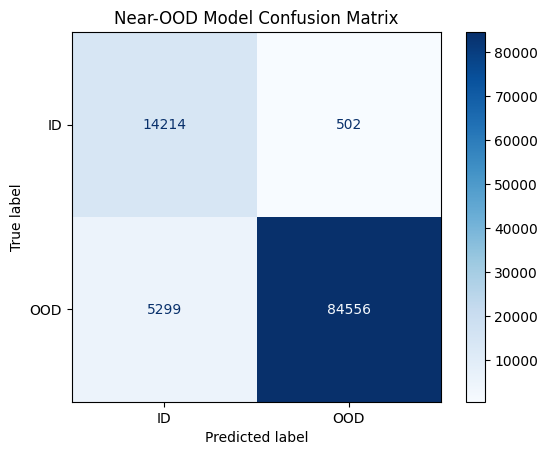

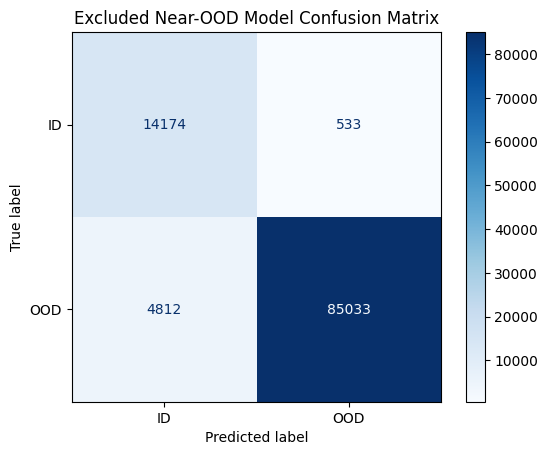

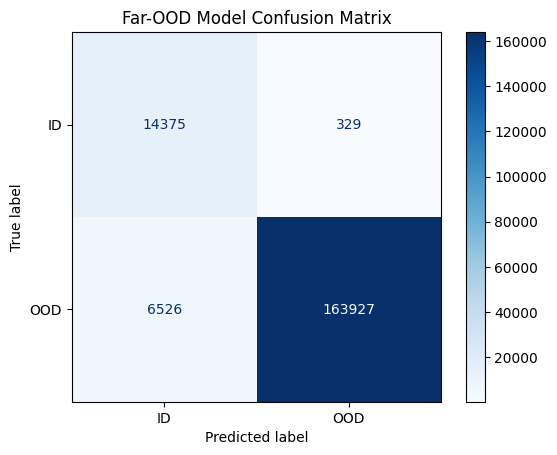

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, dataset, title):
    # Get predictions
    predictions = model.predict(dataset).predictions.argmax(axis=1)
    true_labels = dataset["labels"]

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ID", "OOD"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot for Near-OOD model
plot_confusion_matrix(trainer_near, test_dataset_near, "Near-OOD Model Confusion Matrix")

# Plot for Excluded Near-OOD model
plot_confusion_matrix(trainer_near_excluded, test_dataset_excluded, "Excluded Near-OOD Model Confusion Matrix")

# Plot for Far-OOD model
plot_confusion_matrix(trainer_far, test_dataset_far, "Far-OOD Model Confusion Matrix")


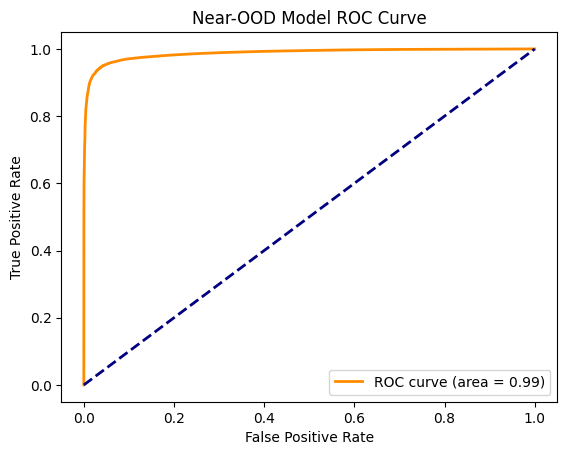

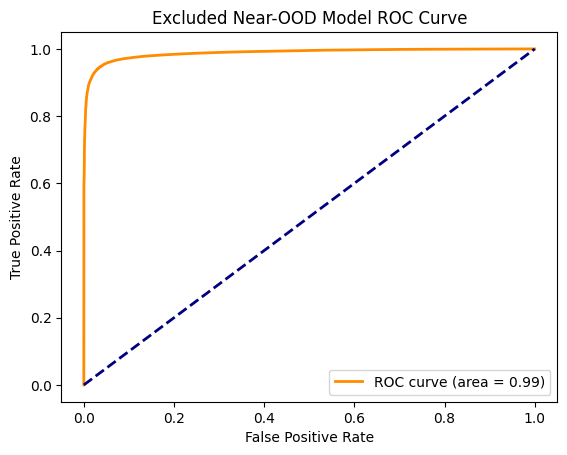

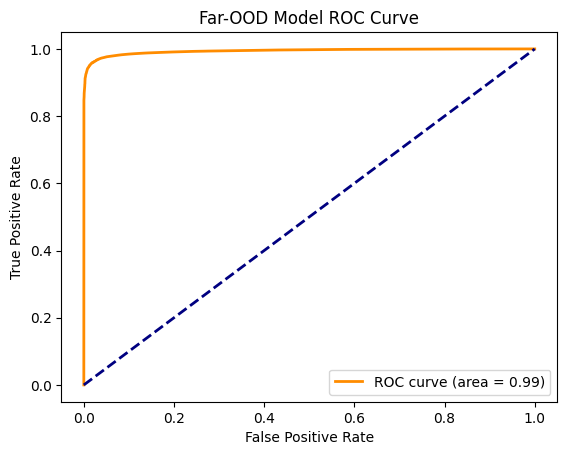

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, dataset, title):
    # Get predictions
    predictions = model.predict(dataset).predictions
    probabilities = predictions[:, 1]  # Probability of class 1 (OOD)
    true_labels = dataset["labels"]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Plot for Near-OOD model
plot_roc_curve(trainer_near, test_dataset_near, "Near-OOD Model ROC Curve")

# Plot for Excluded Near-OOD model
plot_roc_curve(trainer_near_excluded, test_dataset_excluded, "Excluded Near-OOD Model ROC Curve")

# Plot for Far-OOD model
plot_roc_curve(trainer_far, test_dataset_far, "Far-OOD Model ROC Curve")


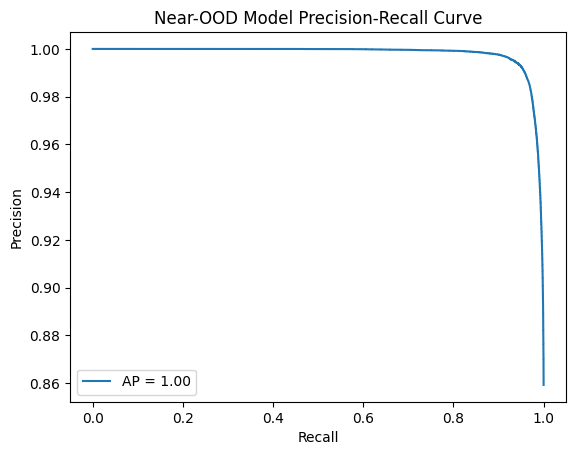

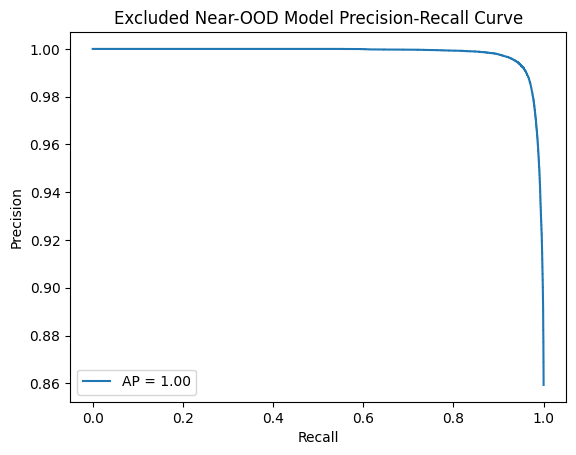

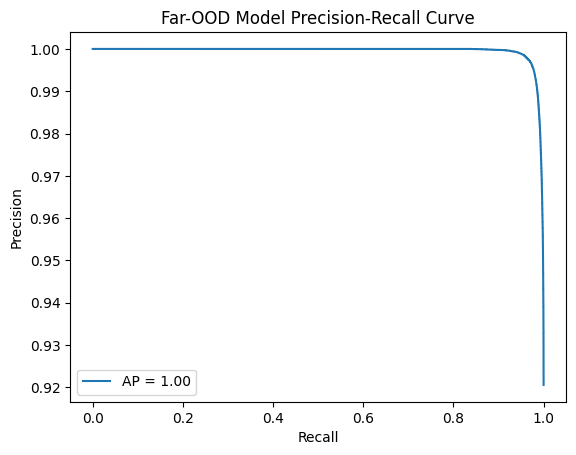

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(model, dataset, title):
    # Get predictions
    predictions = model.predict(dataset).predictions
    probabilities = predictions[:, 1]  # Probability of class 1 (OOD)
    true_labels = dataset["labels"]

    # Compute PR curve
    precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)
    avg_precision = average_precision_score(true_labels, probabilities)

    # Plot PR curve
    plt.figure()
    plt.step(recall, precision, where="post", label=f"AP = {avg_precision:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

# Plot for Near-OOD model
plot_precision_recall_curve(trainer_near, test_dataset_near, "Near-OOD Model Precision-Recall Curve")

# Plot for Excluded Near-OOD model
plot_precision_recall_curve(trainer_near_excluded, test_dataset_excluded, "Excluded Near-OOD Model Precision-Recall Curve")

# Plot for Far-OOD model
plot_precision_recall_curve(trainer_far, test_dataset_far, "Far-OOD Model Precision-Recall Curve")


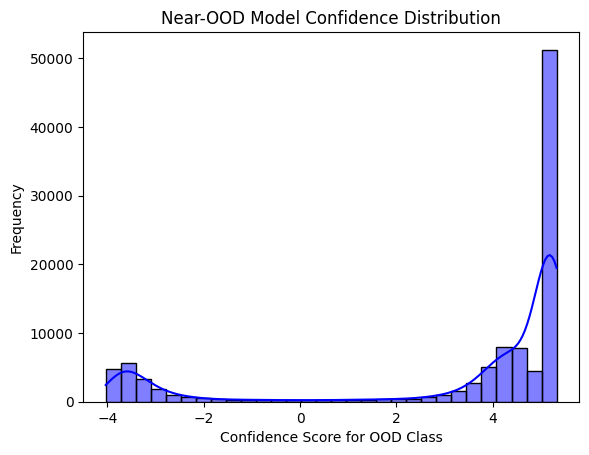

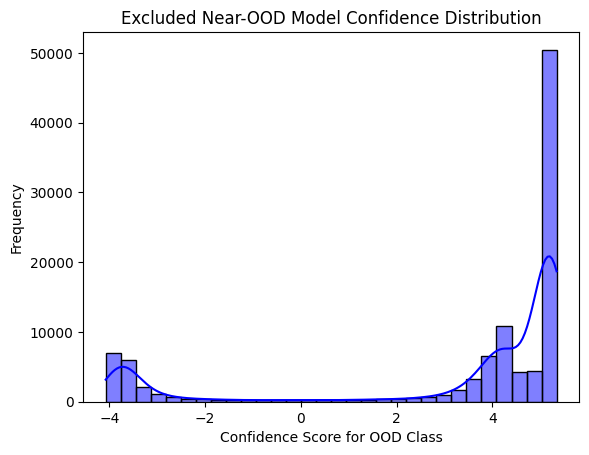

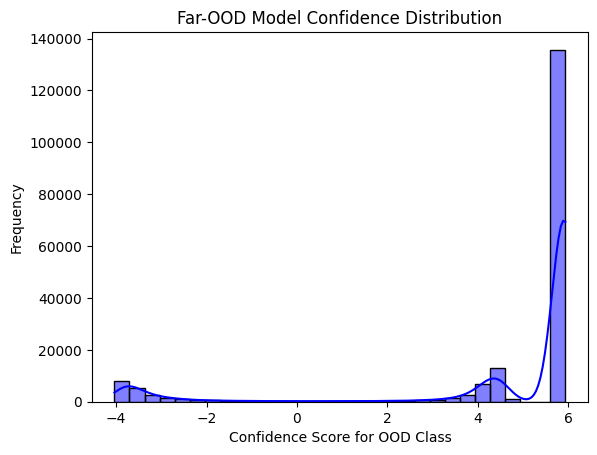

In [ ]:
import seaborn as sns

def plot_confidence_distribution(model, dataset, title):
    # Get predictions
    predictions = model.predict(dataset).predictions
    probabilities = predictions[:, 1]  # Probability of class 1 (OOD)

    # Plot distribution
    plt.figure()
    sns.histplot(probabilities, kde=True, bins=30, color="blue")
    plt.title(title)
    plt.xlabel("Confidence Score for OOD Class")
    plt.ylabel("Frequency")
    plt.show()

# Plot for Near-OOD model
plot_confidence_distribution(trainer_near, test_dataset_near, "Near-OOD Model Confidence Distribution")

# Plot for Excluded Near-OOD model
plot_confidence_distribution(trainer_near_excluded, test_dataset_excluded, "Excluded Near-OOD Model Confidence Distribution")

# Plot for Far-OOD model
plot_confidence_distribution(trainer_far, test_dataset_far, "Far-OOD Model Confidence Distribution")


In [ ]:
# Check label distribution
from collections import Counter
labels = [entry["labels"] for entry in train_dataset_near]
print(f"Label distribution: {Counter(labels)}")


Label distribution: Counter({1: 67349})


In [ ]:
import pandas as pd

# Collect evaluation results
results = {
    "Model": ["Near-OOD", "Excluded Near-OOD", "Far-OOD"],
    "Accuracy": [results_near["eval_accuracy"], results_near_excluded["eval_accuracy"], results_far["eval_accuracy"]],
    "Loss": [results_near["eval_loss"], results_near_excluded["eval_loss"], results_far["eval_loss"]],
}

# Create a DataFrame
metrics_df = pd.DataFrame(results)

# Display the table
print(metrics_df)


KeyError: 'eval_accuracy'

In [ ]:
import numpy as np
from sklearn.utils import resample

# Subsample to equal class sizes
id_indices = np.where(np.array(y_true) == 0)[0]  # Indices of ID samples
ood_indices = np.where(np.array(y_true) == 1)[0]  # Indices of OOD samples
ood_sampled_indices = resample(ood_indices, replace=False, n_samples=len(id_indices), random_state=42)

# Combine balanced indices
balanced_indices = np.concatenate([id_indices, ood_sampled_indices])
balanced_y_true = np.array(y_true)[balanced_indices]
balanced_y_pred = np.array(y_pred)[balanced_indices]

# Compute balanced accuracy
balanced_acc = np.mean(balanced_y_true == balanced_y_pred)
print(f"Balanced Accuracy (Equal Class Sizes): {balanced_acc:.4f}")


NameError: name 'y_true' is not defined

In [ ]:
import numpy as np
from sklearn.utils import resample
from datasets import Dataset

def balance_test_dataset(dataset):
    """
    Balance the test dataset by downsampling the majority class.
    """
    labels = np.array(dataset["labels"])
    input_ids = np.array(dataset["input_ids"])
    attention_mask = np.array(dataset["attention_mask"])

    # Separate indices by label
    id_indices = np.where(labels == 0)[0]  # ID samples
    ood_indices = np.where(labels == 1)[0]  # OOD samples

    # Balance the dataset by downsampling the majority class
    min_class_size = min(len(id_indices), len(ood_indices))
    balanced_id_indices = resample(id_indices, replace=False, n_samples=min_class_size, random_state=42)
    balanced_ood_indices = resample(ood_indices, replace=False, n_samples=min_class_size, random_state=42)

    # Combine the indices
    balanced_indices = np.concatenate([balanced_id_indices, balanced_ood_indices])
    np.random.shuffle(balanced_indices)

    # Create balanced dataset
    balanced_dataset = {
        "input_ids": input_ids[balanced_indices],
        "attention_mask": attention_mask[balanced_indices],
        "labels": labels[balanced_indices],
    }
    return Dataset.from_dict(balanced_dataset)

# Assume `test_dataset_near` is your original test dataset
balanced_test_dataset = balance_test_dataset(test_dataset_near)


In [ ]:
# Load the trained model (replace with your saved model path)
from transformers import AutoModelForSequenceClassification, Trainer

near_ood_model = AutoModelForSequenceClassification.from_pretrained("./near_ood_model")

# Define a Trainer for evaluation
trainer_near = Trainer(
    model=near_ood_model
)

# Predict probabilities on the balanced test dataset
predictions = trainer_near.predict(balanced_test_dataset)
probabilities = predictions.predictions[:, 1]  # OOD class probabilities
true_labels = balanced_test_dataset["labels"]


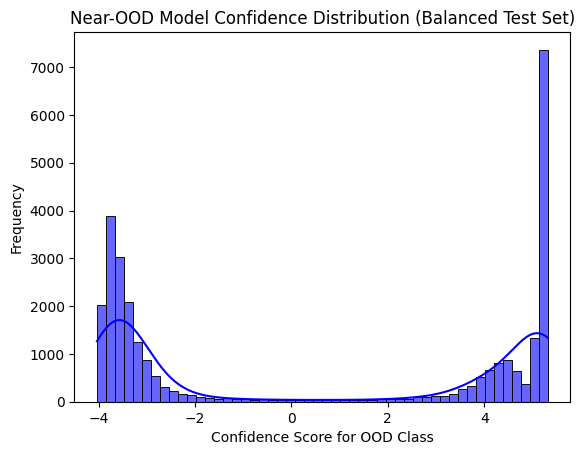

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confidence distribution for the OOD class
sns.histplot(probabilities, kde=True, bins=50, color="blue", alpha=0.6)
plt.xlabel("Confidence Score for OOD Class")
plt.ylabel("Frequency")
plt.title("Near-OOD Model Confidence Distribution (Balanced Test Set)")
plt.show()


<ipython-input-80-cd3803914b89>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(id_confidences, label="ID", shade=True, color="blue")
<ipython-input-80-cd3803914b89>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ood_confidences, label="OOD", shade=True, color="orange")


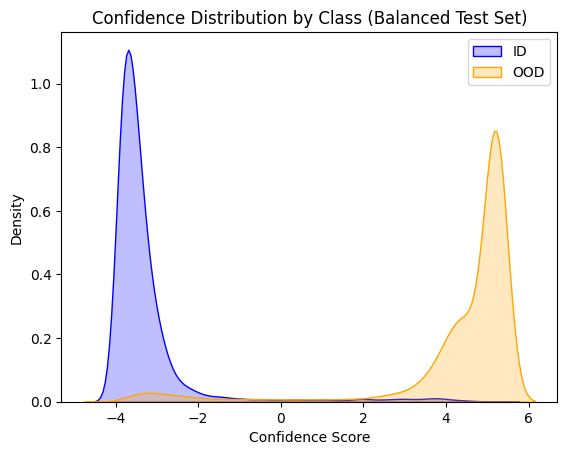

In [ ]:
# Separate confidence scores by true label
id_confidences = probabilities[np.array(true_labels) == 0]
ood_confidences = probabilities[np.array(true_labels) == 1]

# Plot confidence distribution for each class
sns.kdeplot(id_confidences, label="ID", shade=True, color="blue")
sns.kdeplot(ood_confidences, label="OOD", shade=True, color="orange")
plt.xlabel("Confidence Score")
plt.ylabel("Density")
plt.title("Confidence Distribution by Class (Balanced Test Set)")
plt.legend()
plt.show()


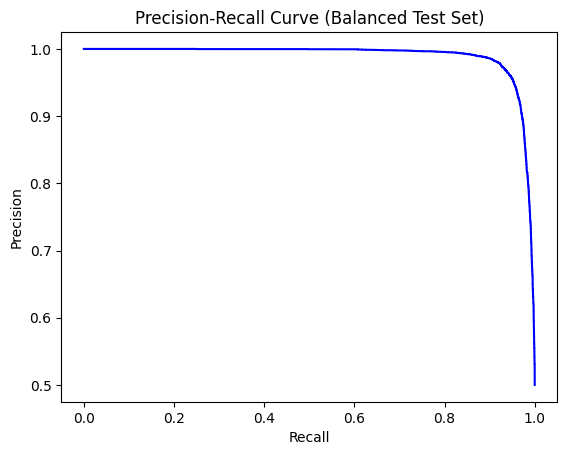

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(true_labels, probabilities)

# Plot precision-recall curve
plt.step(recall, precision, where="post", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Balanced Test Set)")
plt.show()


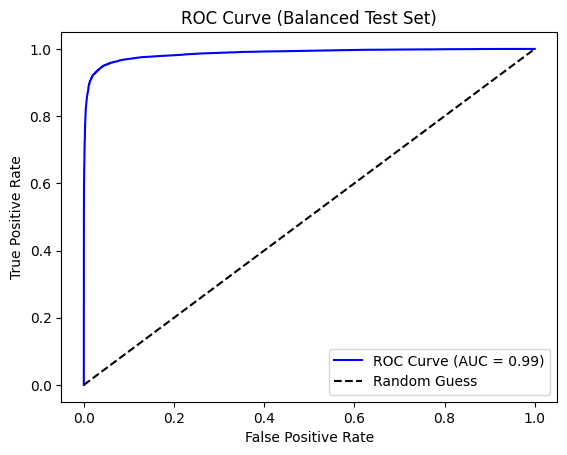

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC values
fpr, tpr, _ = roc_curve(true_labels, probabilities)
roc_auc = roc_auc_score(true_labels, probabilities)

# Plot ROC curve
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Balanced Test Set)")
plt.legend()
plt.show()


In [ ]:
### Leakage check

In [ ]:
# Check for overlaps between train and test sets
train_ids = set(train_dataset_near["input_ids"].tolist())
test_ids = set(test_dataset_near["input_ids"].tolist())

overlap = train_ids.intersection(test_ids)
print(f"Number of overlapping samples: {len(overlap)}")


TypeError: unhashable type: 'list'

##  cross evaluation

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Common tokenization function
def tokenize_data(data, max_length=128):
    """
    Tokenize the input data with consistent parameters.
    """
    tokenized = tokenizer(
        data,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return tokenized


In [ ]:
# Inspect SST-2 data
sst2_data = torch.load(os.path.join(save_dir, "sst2_val.pt"))
print("SST-2 Data Type:", type(sst2_data))
if isinstance(sst2_data, dict):
    print("Keys:", sst2_data.keys())
    print("Sample data:", sst2_data["input_ids"][:5])  # Adjust key if needed
else:
    print("Sample SST-2 data:", sst2_data[:5])  # Adjust indexing if it's a list or other iterable

# Inspect Toxic data
toxic_raw_data = torch.load(os.path.join(save_dir, "far_ood_classifier_data.pt"))
print("Toxic Data Type:", type(toxic_raw_data))
if isinstance(toxic_raw_data, dict):
    print("Keys:", toxic_raw_data.keys())
    print("Sample data:", toxic_raw_data["input_ids"][:5])  # Adjust key if needed
else:
    print("Sample Toxic data:", toxic_raw_data[:5])  # Adjust indexing if it's a list or other iterable


<ipython-input-90-9e51be632bd2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sst2_data = torch.load(os.path.join(save_dir, "sst2_val.pt"))
<ipython-input-90-9e51be632bd2

SST-2 Data Type: <class 'transformers.tokenization_utils_base.BatchEncoding'>
Sample SST-2 data: [Encoding(num_tokens=55, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=55, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=55, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=55, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=55, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])]
Toxic Data Type: <class 'transformers.tokenization_utils_base.BatchEncoding'>
Sample Toxic data: [Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]), Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask

In [ ]:
sst2_tokenized = sst2_data  # Use as-is if already tokenized


In [ ]:
# Inspect the structure of sst2_data
print("Type of sst2_data:", type(sst2_data))

# Print a sample of the data (first 5 entries or the whole thing if it's a single string)
print("Sample of sst2_data:", sst2_data[:5] if isinstance(sst2_data, list) else sst2_data)



Type of sst2_data: <class 'transformers.tokenization_utils_base.BatchEncoding'>
Sample of sst2_data: {'input_ids': tensor([[  101,  2009,  1005,  ...,     0,     0,     0],
        [  101,  4895, 10258,  ...,     0,     0,     0],
        [  101,  4473,  2149,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  3395,  ...,     0,     0,     0],
        [  101,  1012,  1012,  ...,     0,     0,     0],
        [  101,  2559, 19774,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 

In [ ]:
sst2_tokenized = tokenize_data(sst2_reviews)


In [ ]:
# Assign labels
sst2_labels = torch.zeros(len(sst2_data["input_ids"]))  # Label as 0 (ID)
toxic_labels = torch.ones(len(toxic_raw_data["input_ids"]))  # Label as 1 (OOD)

# Combine datasets
combined_input_ids = torch.cat([sst2_data["input_ids"], toxic_raw_data["input_ids"]], dim=0)
combined_attention_mask = torch.cat([sst2_data["attention_mask"], toxic_raw_data["attention_mask"]], dim=0)
combined_labels = torch.cat([sst2_labels, toxic_labels], dim=0)

# Save combined dataset
combined_data = {
    "input_ids": combined_input_ids,
    "attention_mask": combined_attention_mask,
    "labels": combined_labels,
}
torch.save(combined_data, "sst2_toxic_combined.pt")


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 128 but got size 512 for tensor number 1 in the list.

<ipython-input-89-262bbccff57a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sst2_data = torch.load(os.path.join(save_dir, "sst2_val.pt"))  # Adjust path as needed
<ipyt

TypeError: string indices must be integers

In [ ]:
# Combine SST-2 (label 0) and toxic texts (label 1) into a single dataset
combined_test_data = {
    "input_ids": torch.cat([sst2_tokenized["input_ids"], toxic_tokenized["input_ids"]], dim=0),
    "attention_mask": torch.cat([sst2_tokenized["attention_mask"], toxic_tokenized["attention_mask"]], dim=0),
    "labels": torch.cat([torch.zeros(len(sst2_tokenized["input_ids"])), torch.ones(len(toxic_tokenized["input_ids"]))], dim=0),
}


In [ ]:
from transformers import Trainer
from datasets import Dataset

# Convert combined data to Hugging Face Dataset format
test_dataset = Dataset.from_dict(combined_test_data)

# Load Near-OOD model
near_ood_model = AutoModelForSequenceClassification.from_pretrained("./near_ood_model")

# Initialize Trainer
trainer = Trainer(model=near_ood_model)

# Predict on the combined test dataset
predictions = trainer.predict(test_dataset)

# Get predicted labels
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

# Print classification report
from sklearn.metrics import classification_report

print("Evaluation Results for Near-OOD Model:")
print(classification_report(test_dataset["labels"], predicted_labels))


In [ ]:
from transformers import Trainer
from sklearn.metrics import classification_report
import torch

# Load the models
near_ood_model = AutoModelForSequenceClassification.from_pretrained("./near_ood_model")
excluded_near_ood_model = AutoModelForSequenceClassification.from_pretrained("./near_ood_excluded_model")

# Load the datasets
sst2_test = torch.load(os.path.join(save_dir, "sst2_val.pt"))  # Test set for SST-2 (sentiments)
toxic_texts = torch.load(os.path.join(save_dir, "far_ood_classifier_data.pt"))  # Toxic examples from BeaverTails

# Combine SST-2 (label 0) and toxic texts (label 1) into a single dataset
sentiments_vs_toxic_data = {
    "input_ids": torch.cat([sst2_test["input_ids"], toxic_texts["input_ids"]], dim=0),
    "attention_mask": torch.cat([sst2_test["attention_mask"], toxic_texts["attention_mask"]], dim=0),
    "labels": torch.cat([torch.zeros(len(sst2_test["labels"])), torch.ones(len(toxic_texts["labels"]))], dim=0),
}

# Convert to Hugging Face Dataset
from datasets import Dataset
sentiments_vs_toxic_dataset = Dataset.from_dict(sentiments_vs_toxic_data)

# Evaluate Near-OOD Model
trainer_near = Trainer(model=near_ood_model)
near_ood_predictions = trainer_near.predict(sentiments_vs_toxic_dataset)
near_ood_pred_labels = torch.argmax(torch.tensor(near_ood_predictions.predictions), dim=1)

print("Near-OOD Model Evaluation (Sentiments vs Toxic Language):")
print(classification_report(sentiments_vs_toxic_dataset["labels"], near_ood_pred_labels))

# Evaluate Excluded Near-OOD Model
trainer_excluded_near = Trainer(model=excluded_near_ood_model)
excluded_near_ood_predictions = trainer_excluded_near.predict(sentiments_vs_toxic_dataset)
excluded_near_ood_pred_labels = torch.argmax(torch.tensor(excluded_near_ood_predictions.predictions), dim=1)

print("Excluded Near-OOD Model Evaluation (Sentiments vs Toxic Language):")
print(classification_report(sentiments_vs_toxic_dataset["labels"], excluded_near_ood_pred_labels))


<ipython-input-85-8ee70c6f2c2d>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sst2_test = torch.load(os.path.join(save_dir, "sst2_val.pt"))  # Test set for SST-2 (sentim

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 55 but got size 512 for tensor number 1 in the list.

In [ ]:
# Load the model
far_ood_model = AutoModelForSequenceClassification.from_pretrained("./far_ood_model")

# Load the blended dataset
blended_test_data = torch.load(os.path.join(save_dir, "near_ood_classifier_data.pt"))  # Blended toxic reviews
sst2_test = torch.load(os.path.join(save_dir, "sst2_val.pt"))  # Sentiments for comparison

# Combine blended examples (label 1) and SST-2 (label 0)
blended_vs_sentiments_data = {
    "input_ids": torch.cat([sst2_test["input_ids"], blended_test_data["input_ids"]], dim=0),
    "attention_mask": torch.cat([sst2_test["attention_mask"], blended_test_data["attention_mask"]], dim=0),
    "labels": torch.cat([torch.zeros(len(sst2_test["labels"])), torch.ones(len(blended_test_data["labels"]))], dim=0),
}

# Convert to Hugging Face Dataset
blended_vs_sentiments_dataset = Dataset.from_dict(blended_vs_sentiments_data)

# Evaluate Far-OOD Model
trainer_far = Trainer(model=far_ood_model)
far_ood_predictions = trainer_far.predict(blended_vs_sentiments_dataset)
far_ood_pred_labels = torch.argmax(torch.tensor(far_ood_predictions.predictions), dim=1)

print("Far-OOD Model Evaluation (Blended Examples vs Sentiments):")
print(classification_report(blended_vs_sentiments_dataset["labels"], far_ood_pred_labels))


<ipython-input-87-7aad68475e0e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  blended_test_data = torch.load(os.path.join(save_dir, "near_ood_classifier_data.pt"))  # Ble

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 55 but got size 213 for tensor number 1 in the list.

# Other methods we discussed



### Confidence scoring for near OOD detection

# LlM inference with OOD detection

In [ ]:
!pip install transformers datasets torch accelerate peft tqdm scikit-learn matplotlib


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the fine-tuned classification model and tokenizer
model_path = "./near_ood_model"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Ensure the model is on the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Define a function to handle the prompt-based workflow
def process_prompt_with_ood_detection(prompt, ood_threshold=0.5):
    """
    Processes a prompt to classify it as OOD or ID and provides sentiment if ID.

    Args:
    - prompt: Input text for classification and sentiment detection.
    - ood_threshold: Confidence threshold for OOD detection.

    Returns:
    - A response based on the OOD/ID classification and sentiment detection.
    """
    # Tokenize the input
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=256
    ).to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = F.softmax(logits, dim=-1)

    # Get confidence for OOD and ID
    ood_confidence = probabilities[0, 1].item()  # Assuming OOD is label 1
    id_confidence = probabilities[0, 0].item()  # Assuming ID is label 0

    # Post-process results
    if ood_confidence > ood_threshold:
        return "This seems like OOD, no sentiment provided."
    else:
        # Example: Assuming ID data includes sentiment classification
        sentiment = "Positive" if id_confidence > 0.5 else "Negative"
        return f"The sentiment is {sentiment}."

# Example Prompts
prompts = [
    "This is completely unrelated to the training data.",
    "The movie was an absolute masterpiece!"
]

for prompt in prompts:
    response = process_prompt_with_ood_detection(prompt)
    print(f"Prompt: {prompt}")
    print(f"Response: {response}\n")


OSError: Incorrect path_or_model_id: './near_ood_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.